{download}`Download this notebook <4_efficiency.ipynb>`

## Optimizing efficiency
### Problem setup
Given a fixed wiring budget, how do you build a network with highest efficiency?

$$E=\frac{1}{N(N-1)}\sum_{i\ne j}\frac{1}{d_{ij}}$$

Where $d_{ij}$ is the shortest path legth between i and j.

Doesn't relax

### GradNet optimization

In [ ]:
from gradnet import GradNet
from gradnet.trainer import fit
from gradnet.utils import shortest_path
import torch

N = 100
budget_per_node = 2.0

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=0.09)

# define the loss function
def loss_fn(gn):
    A = gn()  # get the adjacency matrix
    L = 1/(A + 1e-9)  # compute the edge-lengths as inverse of weights
    D = shortest_path(L, pair="full")

    eff = (D**-1).triu(1).float().sum() / (D.size(0) * (D.size(0) - 1) // 2)

    return -eff

fit(gn=gn, loss_fn=loss_fn, num_updates=1000, optim_kwargs={"lr": 0.005}, accelerator="cpu");

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/guga/D/University/UWyo/Network_Optimization/gradnet/examples/lightning_logs


Updates:   0%|          | 0/1000 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 10.0 K | train
-----------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1000` reached.


### Plot the results

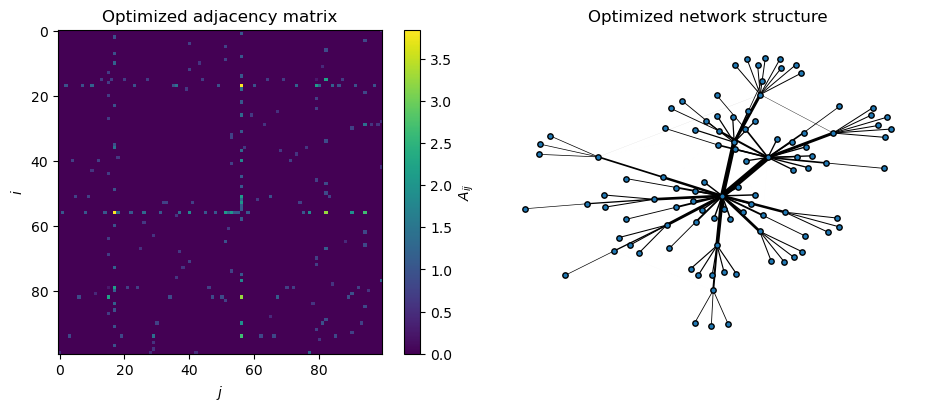

In [12]:
from matplotlib import pyplot as plt
import networkx as nx
from gradnet.utils import to_networkx
# Convert adjacency matrix to NetworkX graph
A = gn().detach().cpu().numpy()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: plot the adjacency matrix as a heatmap
im0 = ax0.imshow(A)
fig.colorbar(im0, ax=ax0, label="$A_{ij}$")
ax0.set(title="Optimized adjacency matrix", xlabel="$j$", ylabel="$i$")

# Right: plot the networkx graph
net = to_networkx(gn)
edge_widths = list(nx.get_edge_attributes(net, 'weight').values())
nx.draw_spring(net, ax=ax1, nodelist=sorted(net.nodes()),
               node_size=15, width=edge_widths, edgecolors="black")
ax1.set(title="Optimized network structure")
plt.show()